<a href="https://colab.research.google.com/github/pachterlab/monod/blob/anndata/Monod_demo_new.ipynb?short_path=e568791" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset. 

# Inference pipeline

## Install prerequisites

In [153]:
# # %%capture
# # !pip install -i https://test.pypi.org/simple/ -U --extra-index-url https://pypi.org/simple   monod  
# # !pip install -i https://pypi.org/simple/  monod  
# !pip install monod

Let's make sure that the version is correct.

In [154]:
# !pip show monod

## Import data

In [155]:
# ! git clone https://github.com/pachterlab/monod_examples.git

In [156]:
# !rm -r sample_data

In [157]:
# !mv monod_examples/* .

In [158]:
# !rm -r monod_examples

In [159]:
# !mv sample_data/* .

In [160]:
# !rmdir sample_data

In [161]:
# !cat allen_C01_gaba.tar.gz.* | tar xzvf -

In [162]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_gaba.loom .

In [163]:
# !cat allen_C01_glu.tar.gz.* | tar xzvf -

In [164]:
# !mv home/ggorin/projects/monod_examples/sample_data/allen_C01_glu.loom .

In [165]:
# !rm -r  ./home

In [166]:
# !rm *.tar.*

## Import package components

In [653]:
# import monod
# from monod import preprocess, extract_data, cme_toolbox, inference, analysis

import matplotlib.pyplot as plt
import numpy as np

In [703]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.DEBUG)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

In [704]:
# execfile("src/monod/preprocess.py")
import sys

# sys.path.insert(0, '/home/mffang/workspace/Monod/monod/src/monod')

import extract_data, cme_toolbox, inference, analysis
import importlib

importlib.reload(extract_data)
importlib.reload(inference)
importlib.reload(cme_toolbox)
importlib.reload(analysis)

<module 'analysis' from '/home/cat/monod/src/monod/analysis.py'>

## Set up model and perform inference.

In [705]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')
transcriptome_filepath = './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

DE_genes = ['Rspo3', 'Erbin','Rcan3' ,'Clic4', 'Vrk1']#, 'Lrp12', 'Gatm' ,'Rims3', '1110004F10Rik', 'Tcerg1l', 'Hcrtr2' ]
demo_genes = ['Eif5b','Xrcc5',	'Klhl12','Rgs7','Thsd7b']
# Perform inference. (don't need to give these bounds, here for debugging but can use defaults.)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
samp_lb, samp_ub = [-8, -3],[-5, 0]
grid = [6,7]

# Define a mapping from modality names from cme_toolbox to anndata layer names. 
# (If none given, equality is assumed).
modality_name_dict  = {'spliced':'spliced', 'unspliced':'unspliced'}

gaba_adata = inference.perform_inference('./gaba_example.h5ad', fitmodel, n_genes=5, seed=4, genes_to_fit=DE_genes,
            phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub, 
            gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1}, 
                                              modality_name_dict=modality_name_dict,
                                         transcriptome_filepath=transcriptome_filepath) 

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Directory gaba_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: gaba_example
is sparse
INFO:root:Added lengths
INFO:root:728 cells detected.
3579 genes retained after expression filter.
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory gaba_example/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to gaba_example/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-p

/home/cat/monod/src/monod/inference.py:114: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  monod_adata.var['param_' + param_name] = param_values


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 0.9 seconds.
INFO:root:Uncertainties per gene calculated.


INFO:root:Figure stored to gaba_example/Bursty_Poisson_6x7/analysis_figures/length_dependence.png.


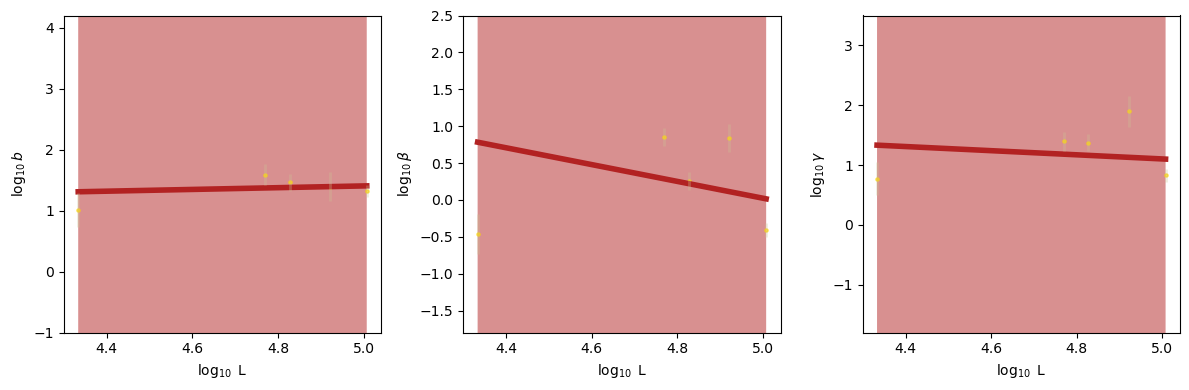

In [708]:
gaba_adata.uns['search_result'].samp_optimum
gaba_adata.uns['search_result'].plot_param_L_dep(plot_fit=True, plot_errorbars=True)

In [707]:
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)


INFO:root:Chi-square computation complete. Rejected 0 genes out of 5. Runtime: 0.0 seconds.


In [681]:
glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=5, seed=4, genes_to_fit=DE_genes,
                                       phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub, 
                                        gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1},
                                       transcriptome_filepath=transcriptome_filepath) #['Eif5b', 'Thsd7b', 'Fbxw2', 'Otud7a', 'Asah1'])glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=5, seed=4, genes_to_fit=DE_genes,

INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


is sparse


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:6629 cells detected.


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


5521 genes retained after expression filter.


/home/cat/monod/src/monod/extract_data.py:873: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_exp_filter[gene_loc[0]] = False


INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory glu_example/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to glu_example/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 26.7 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved.
Layers with keys: unspliced, spliced
['unspliced', 'spliced']

/home/cat/monod/src/monod/inference.py:114: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  log.info('AIC values calculated.')


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.1 seconds.
INFO:root:Uncertainties per gene calculated.


In [ ]:
# # NB currently can't save whole object to file since some .uns attributes cannot be pickled.
# gaba_adata.write('gaba_fit.h5ad')
# gaba_adata.write('glu_fit.h5ad')

## Access gene info.

In [682]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters.
display(gaba_adata.var[[i for i in new_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(gaba_adata.var[[i for i in new_adata.var.keys() if 'sigma' in i]])

,AIC
gene_name,
Rspo3,1051.807514
Vrk1,2685.281112
Erbin,5341.835140
Rcan3,2716.916103
Clic4,1753.019133


,param_$\log_{10} b$,param_$\log_{10} \beta$,param_$\log_{10} \gamma$
gene_name,,,
Rspo3,1.393542,0.838267,1.897753
Vrk1,1.468275,0.256774,1.374823
Erbin,1.323164,-0.405559,0.827421
Rcan3,1.019414,-0.459644,0.774511
Clic4,1.586942,0.855411,1.397246


,sigma_$\log_{10} b$,sigma_$\log_{10} \beta$,sigma_$\log_{10} \gamma$
gene_name,,,
Rspo3,1.393542,0.838267,1.897753
Vrk1,1.468275,0.256774,1.374823
Erbin,1.323164,-0.405559,0.827421
Rcan3,1.019414,-0.459644,0.774511
Clic4,1.586942,0.855411,1.397246


In [683]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters.
display(glu_adata.var[[i for i in new_adata.var.keys() if 'param' in i]])

# Uncertainties from Hessian.
display(glu_adata.var[[i for i in new_adata.var.keys() if 'sigma' in i]])

,AIC
gene_name,
Rspo3,21296.635566
Vrk1,15888.053165
Erbin,13098.356659
Rcan3,4428.899354
Clic4,2787.016388


,param_$\log_{10} b$,param_$\log_{10} \beta$,param_$\log_{10} \gamma$
gene_name,,,
Rspo3,1.280592,0.267672,0.369304
Vrk1,0.888506,-0.038028,0.254739
Erbin,1.352959,0.691909,0.790293
Rcan3,1.382229,0.936958,1.235582
Clic4,1.643626,1.803793,1.685088


,sigma_$\log_{10} b$,sigma_$\log_{10} \beta$,sigma_$\log_{10} \gamma$
gene_name,,,
Rspo3,1.280592,0.267672,0.369304
Vrk1,0.888506,-0.038028,0.254739
Erbin,1.352959,0.691909,0.790293
Rcan3,1.382229,0.936958,1.235582
Clic4,1.643626,1.803793,1.685088


Plot parameter distributions.

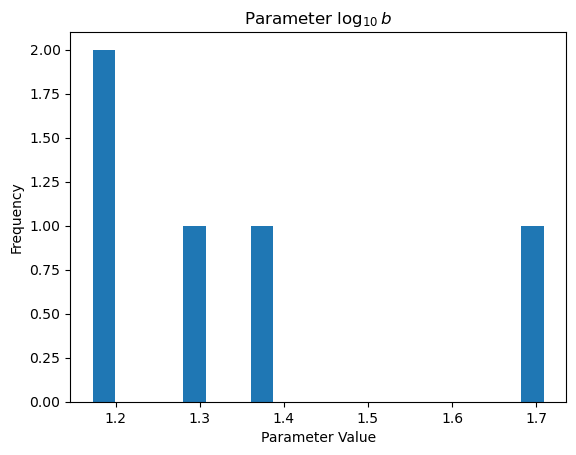

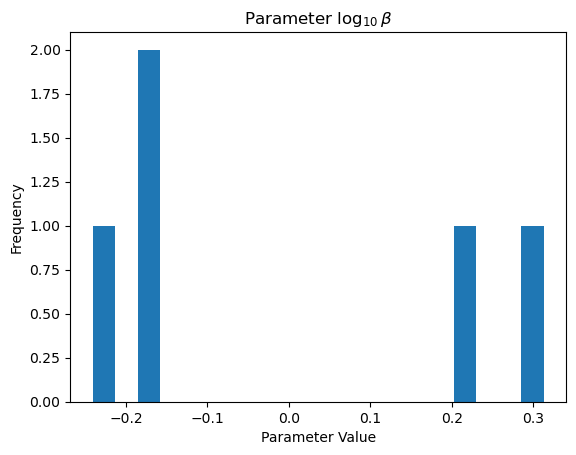

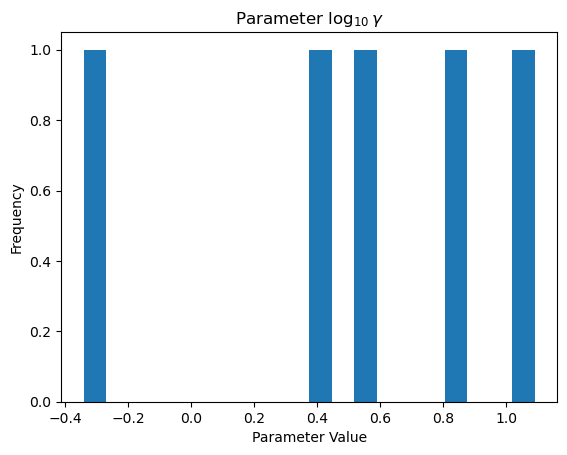

In [679]:
param_names = [i for i in gaba_adata.var.keys() if 'param' in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name[6:])
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

# Analysis (to be implemented)

## Reject genes.

In [699]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[['rejected_genes', 'csq', 'pval']])
display(gaba_adata.var[['rejected_genes', 'csq', 'pval']])

# # Save chi-square values.
chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:Chi-square computation complete. Rejected 0 genes out of 5. Runtime: 0.0 seconds.
[3.904e+03 6.270e+02 9.800e+01 1.300e+01 3.000e+00 8.200e+02 1.920e+02
 6.000e+01 1.000e+01 2.000e+00 1.000e+00 3.260e+02 1.110e+02 3.100e+01
 8.000e+00 3.000e+00 1.550e+02 5.700e+01 2.400e+01 5.000e+00 6.700e+01
 2.700e+01 3.000e+00 2.000e+00 1.000e+00 1.000e+00 2.300e+01 1.400e+01
 3.000e+00 1.000e+00 1.000e+01 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 2.000e+00 1.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00] counts
[3904.  627.   98.   13.  823.  192.   60.   10.  329.  111.   31.    8.
  158.   57.   24.    5.   67.   27.    5.   25.   14.   14.    8.    5.
    9.    5.]
[3927.04268236  549.21610982   91.66201966   15.0950047   853.68634327
  261.45646389   63.17345593   13.53541175  306.43384593  122.60260766
   36.17927684    9.12307264  122.56584748   57.20798252   19.29853454
    5.4685671    50

,rejected_genes,csq,pval
gene_name,,,
Rspo3,False,66.379311,2.424927e-06
Vrk1,False,12.284280,1.977533e-01
Erbin,False,27.893233,3.256057e-02
Rcan3,False,2.673384,6.138801e-01
Clic4,False,121.272488,1.687231e-24


,rejected_genes,csq,pval
gene_name,,,
Rspo3,False,12.702138,0.005327
Vrk1,False,11.001630,0.357391
Erbin,False,65.415145,0.000657
Rcan3,False,21.462925,0.006014
Clic4,False,20.579755,0.008352


In [687]:
! python --version

Python 3.12.2


## Execute differential expression analysis.

/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[           length_given  lengths  log_lengths  gene_exp_filter  length  \
gene_name                                                                
Vrk1                  1  67199.0     4.827363            False   67199   

           selected_genes  MOM_unspliced_mean  MOM_unspliced_var  \
gene_name                                                          
Vrk1                 True            0.359029           0.501058   

           MOM_spliced_mean  MOM_spliced_var  MOM_cov_unspliced_spliced  
gene_name                                                                
Vrk1               0.135767         0.158064                   0.022461  , Empty DataFrame
Columns: [length_given, lengths, log_lengths, gene_exp_filter, length, selected_genes, MOM_unspliced_mean, MOM_unspliced_var, MOM_spliced_mean, MOM_spliced_var, MOM_cov_unspliced_spliced]
Index: [], Empty DataFrame
Columns: [length_given, lengths, log_lengths, gene_exp_filter, length, selected_genes, MOM_unspliced_mean, MOM_unspli

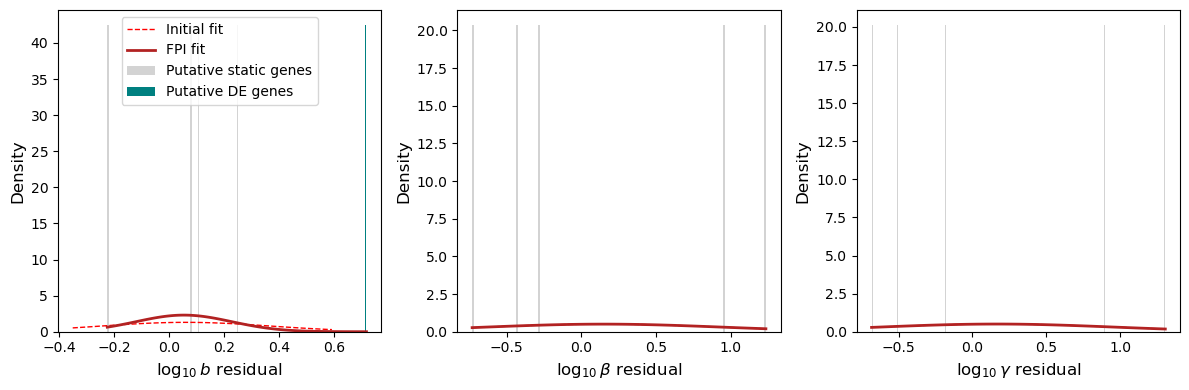

In [685]:
# Compute FCs and p-values between groups in adata.
# This function should also store this information as .uns matrices in adata.

DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata, viz=True, pval_thr=0.1)

# # For two different objects, this is implemented in Monod.
# gn: list of lists of str
#         list of size n_phys_pars. each entry contains names of genes identified as DE with respect
#         to each parameter.
#     gf: bool np.ndarray
#         an n_phys_pars x n_genes array. if True, the gene has been identified as DE with respect to
#         the parameter.
#     offs: float np.ndarray
#         an n_phys_pars x n_model_pars array. contains (b) or (b,a) for each physical parameter.
#         b should typically be fairly small (under 0.5).
#     resid: float np.ndarray
#         an n_phys_pars x n_genes array. contains residuals for each parameter under the final
#         fit statistical model.

print(DE_genes)
# FCs, p_values = analysis.DE(adata)

In [553]:
# # NB changing loom to h5ad.
# adata_gaba = anndata.read_loom('monod_examples/sample_data/allen_C01_gaba.loom')
# adata_gaba.var_names = adata_gaba.var['gene_name']
# adata_gaba.obs_names = adata_gaba.obs['barcode']
# adata_gaba.obs = adata_gaba.obs.drop(columns=['barcode'])
# adata_gaba.var = adata_gaba.var.drop(columns=['gene_name'])
# adata_gaba.write('gaba_example.h5ad')

### Show some gene distributions.

[0 1 2]
Rspo3
Vrk1
Erbin


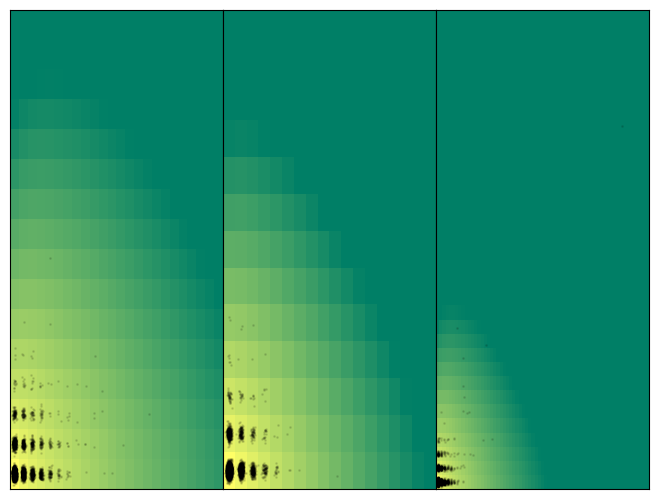

In [688]:
fitted_adata = glu_adata

search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

print(genes_to_plot)
for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])
    
    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']
    
    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1
            
    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])
    
    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')
            
        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names.index[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)
